# Tasks 2, 3 and 4

The following notebook contains the solution for Task 2, 3 and 4

## Task 2

In [1]:
import pandas as pd
import numpy as np
import random

In [2]:
def generate_meter_list(size, zones):
    """
        Generate a pandas dataframe with random meters, annual quantity and exit zone
        
        :param size: number of meters to generate
        :param zones: list with all valid exit zones
        
        :return: Dataframe containing the generated list of meters
    """
    data = pd.DataFrame(columns=["meter_id", "aq_kwh", "exit_zone"])
    meter_ids = []
    aq_kwhs = []
    exit_zones = []
    for _ in range(size):
        meterID = random.randint(0,100000000)
        while meterID in meter_ids:
            meterID = random.randint(0,100000000)
        meter_ids.append(random.randint(0,10000000))
        
        aq_kwhs.append(random.uniform(1000, 100000))
        exit_zones.append(random.choice(zones))
        
    return pd.DataFrame(data={"meter_id": meter_ids, "aq_kwh": aq_kwhs, "exit_zone": exit_zones })

In [3]:
# Get all unique exit_zones from the rate table

rates = pd.read_excel("gorilla_test_data.xlsx", sheet_name="rate_table")
exit_zones = rates.exit_zone.unique()


generate_meter_list(10, zones=exit_zones)

,meter_id,aq_kwh,exit_zone
0,1742966,23023.946329,NO2
1,2140946,58754.905008,NW2
2,8780873,66662.232367,EA1
3,655868,22003.779917,EM1
4,9721405,21127.539897,EM1
5,9152807,25092.538569,NW1
6,5031297,34313.841331,NT3
7,2192062,62013.832976,WM3
8,3961543,76857.861619,LW
9,8103568,16223.126189,EM2


## Task 3

In [4]:
import datetime

def generate_forecast(meters, start_date, duration):
    """
        Generate a pandas dataframe with random forecasts for the given meters and the given period
        
        :param meters: list of meters to include in the forecast 
        :param start_date: string indicating the start date (YYYY-MM-DD format)
        :param duration: number of days to include in the forecast
        
        :return: Dataframe containing the generated forecast
    """
    start_date = datetime.datetime.strptime(start_date, "%Y-%m-%d")
    
    meter_ids = []
    dates = []
    kwhs = []
    
    for meter in meters:
        for delta in range(duration):
            date = start_date + datetime.timedelta(days=delta)
            dates.append(date)
            meter_ids.append(meter)
            kwhs.append(random.uniform(5, 100))
    
    return pd.DataFrame(data={"meter_id": meter_ids, "date": dates,"kwh": kwhs})

In [5]:
generate_forecast([123, 456, 789], "2022-01-01", 2)

,meter_id,date,kwh
0,123,2022-01-01,70.320515
1,123,2022-01-02,61.853753
2,456,2022-01-01,48.719219
3,456,2022-01-02,24.907856
4,789,2022-01-01,28.813696
5,789,2022-01-02,64.760149


## Task 4

In [6]:
def calc_transportation_cost(meters, forecasts):
    """
        Calculate the transportation costs for a number of meters given the forecasts for a certain period
    """
    # Get valid rates from original data
    rates = pd.read_excel("gorilla_test_data.xlsx", sheet_name="rate_table")
    
    # Merge forecasts with the meters
    forecasts = forecasts.merge(right=meters, on="meter_id")
    
    # Merge rates with meters and get correct rates based on aq_kwh
    rates = rates.merge(right=meters, on="exit_zone")
    rates = rates[((rates.aq_kwh >= rates.aq_min_kwh) & (rates.aq_kwh < rates.aq_max_kwh)) | ((rates.aq_max_kwh.isnull()) & (rates.aq_kwh >= rates.aq_min_kwh))]
    rates = rates.drop(["aq_min_kwh", "aq_max_kwh", "exit_zone"], axis=1)
    
    # Get all daily rates for all forecasts

    # Get list of all dates
    dates = sorted(rates.date.unique())
    # Get index where date should be inserted to maintain order of dates
    date_indices = np.searchsorted(dates, forecasts.date, side="right") - 1
    # Add start date of period
    forecasts["rate_period"] = [dates[i] for i in date_indices]
    
    # Combine forcasts with actual rates
    forecasts = forecasts.merge(right=rates, right_on=["date", "meter_id"], left_on=["rate_period", "meter_id"])
    
    # Calculate daily rate (in p)
    forecasts["daily_rate"] = forecasts.kwh * forecasts.rate_p_per_kwh
    
    # Calculate total per meter_id
    totals_per_meter = forecasts.groupby(forecasts.meter_id).sum()[["kwh", "daily_rate"]]
    totals_per_meter.daily_rate = totals_per_meter.daily_rate / 100
    
    # Adjust formatting of dataframe
    totals_per_meter.columns = ["Total Estimated consumption (kWh)", "Total Cost (£)"]
    totals_per_meter.round(2)
    return totals_per_meter

In [50]:
from timeit import default_timer as timer

meter_size = []
forecast_days = []
duration = []

# Run calculations for various sizes
for n_meters in range(1, 10000, 1000):
    for n_days in range(1, 1000, 100):
        # Generate meters and forecast
        meters = generate_meter_list(n_meters, zones=exit_zones)
        forecast = generate_forecast(meters.meter_id, "2020-10-01", n_days)

        # Run actual transportation cost calculations
        start = timer()
        calc_transportation_cost(meters, forecast)
        duration.append(timer() - start)
        
        meter_size.append(n_meters)
        forecast_days.append(n_days)
        
# Store results in dataframe
durations = pd.DataFrame(data={"# meters": meter_size, "# days": forecast_days, "duration": duration})

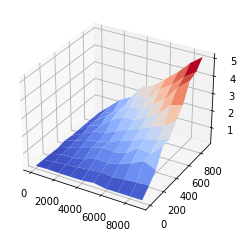

In [51]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# Create 3D-plot of duration in function of amount of meters and number of days
meters = sorted(durations["# meters"].unique())
days = sorted(durations["# days"].unique())

duration = np.zeros(shape=(len(days), len(meters)))

for i in range(len(days)):
    for j in range(len(meters)):
        duration[i,j] = durations[(durations["# meters"] == meters[j]) & (durations["# days"] == days[i])].duration

meters, days = np.meshgrid(meters, days)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(meters, days, duration, cmap=cm.coolwarm)

In [52]:
durations

,# meters,# days,duration
0,1,1,0.206560
1,1,101,0.203024
2,1,201,0.190007
3,1,301,0.161596
4,1,401,0.254343
...,...,...,...
95,9001,501,2.878355
96,9001,601,3.422438
97,9001,701,4.449165
98,9001,801,4.630031
